In [1]:
import os
import zipfile

In [2]:
# # uncomment if the dataset is not loaded
# # name of the zip file you want to unzip
# local_zip = 'image-processing.zip'
# # opening a file with mode parameter 'r' : read existing file
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# # extract all contents of the zip file
# zip_ref.extractall('')
# # close the file
# zip_ref.close()


In [3]:
import tensorflow

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import gc

In [5]:
import os
os.listdir()


['.amlignore',
 '.amlignore.amltmp',
 '.ipynb_aml_checkpoints',
 'cardiomegaly.png',
 'image-processing.zip',
 'MultiDiseasePrediction.html',
 'multidiseaseprediction.html.amltmp',
 'MultiDiseasePrediction.ipynb',
 'multidiseaseprediction.ipynb.amltmp',
 'test-20230326T155708Z-001',
 'train-20230326T152931Z-001',
 'val-20230326T152503Z-001',
 'vgg-acc-md-1.png',
 'vgg-loss-md-1.png']

In [6]:
test_path="test-20230326T155708Z-001/test"
train_path="train-20230326T152931Z-001/train"
val_path="val-20230326T152503Z-001/val"

We will be training a VGG-19 model on our custom training dataset to classify among the six categories - Cardiomegaly, Covid,Normal, Pneumonia, Pneumothorax, Tuberculosis. The pre-trained CNN model inputs a color image of dimensions 224×224 of one of the disease categories. However, all the images of the dataset are of different dimensions. Hence, they must all be resized to the required dimension.



In [7]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

In [8]:
x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)


In [9]:
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)


Now, x_train,x_test, and x_val must be divided by 255.0 for normalization.


In [10]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0


Clearing x_train, x_test and x_val to save memory

In [11]:
del x_train,x_test,x_val
gc.collect()


22

Now we need to add labels to the images, which are the 5 diseases and a normal class


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 9971 images belonging to 6 classes.
Found 1966 images belonging to 6 classes.
Found 1962 images belonging to 6 classes.


In [13]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes
print(train_y,test_y,val_y) 

[0 0 0 ... 5 5 5] [0 0 0 ... 5 5 5] [0 0 0 ... 5 5 5]


In [14]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((9971,), (1966,), (1962,))

In [15]:
del training_set,test_set,val_set
gc.collect()

0

In [16]:
IMAGE_SIZE  = (224, 224,3)
vgg = VGG19(input_shape = IMAGE_SIZE ,weights='imagenet', include_top=False)

2023-03-31 13:16:43.186184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-31 13:16:43.355214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2023-03-31 13:16:43.410720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-31 13:16:44.147055: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-31 13:16:44.429247: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-03-31 13:16:44.582553: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [17]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False


In [18]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(6, activation='softmax')(x)

In [19]:
model = Model(inputs=vgg.input, outputs=prediction)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [23]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=15,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)


2023-03-31 13:17:19.821490: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 6003658752 exceeds 10% of free system memory.
2023-03-31 13:17:23.744198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-31 13:17:28.040388: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Epoch 1/15
312/312 [==============================] - 128s 410ms/step - loss: 0.6114 - accuracy: 0.8009 - val_loss: 0.7038 - val_accuracy: 0.7559
Epoch 2/15
312/312 [==============================] - 125s 402ms/step - loss: 0.3110 - accuracy: 0.8970 - val_loss: 0.3366 - val_accuracy: 0.8889
Epoch 3/15
312/312 [==============================] - 126s 404ms/step - loss: 0.2642 - accuracy: 0.9093 - val_loss: 0.3009 - val_accuracy: 0.9001
Epoch 4/15
312/312 [==============================] - 127s 407ms/step - loss: 0.1923 - accuracy: 0.9351 - val_loss: 0.3108 - val_accuracy: 0.9021
Epoch 5/15
312/312 [==============================] - 127s 408ms/step - loss: 0.1654 - accuracy: 0.9429 - val_loss: 0.2890 - val_accuracy: 0.9052
Epoch 6/15
312/312 [==============================] - 127s 408ms/step - loss: 0.

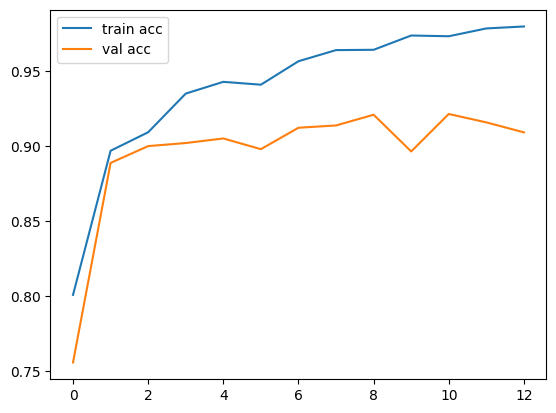

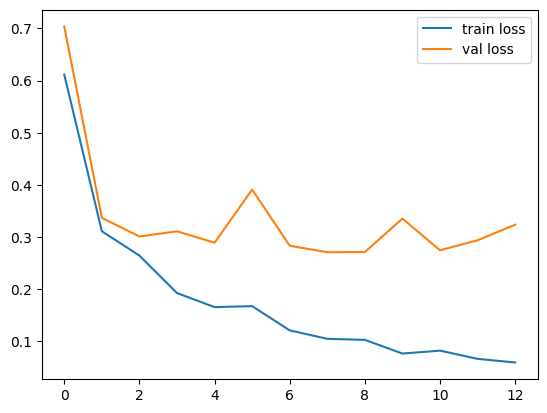

In [24]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-md-1.png')

plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-md-1.png')
plt.show()

In [25]:
model.evaluate(test_x,test_y,batch_size=32)

62/62 [==============================] - 22s 357ms/step - loss: 0.3240 - accuracy: 0.9115


[0.32398149371147156, 0.9114954471588135]

In [26]:
#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
#get classification report


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
print(classification_report(y_pred,test_y))
#get confusion matrix
cm = confusion_matrix(y_pred,test_y)
print(cm)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       269
           1       0.95      0.82      0.88       177
           2       0.87      0.92      0.90       653
           3       0.91      0.98      0.94       451
           4       0.91      0.79      0.85       342
           5       0.99      0.93      0.96        74

    accuracy                           0.91      1966
   macro avg       0.93      0.91      0.92      1966
weighted avg       0.91      0.91      0.91      1966

[[269   0   0   0   0   0]
 [  2 145  17   4   9   0]
 [  1   4 599  33  16   0]
 [  0   0  11 440   0   0]
 [  6   2  57   6 270   1]
 [  1   2   1   0   1  69]]


In [29]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['0','1','2','3','4','5'] , columns = ['0','1','2','3','4','5'])

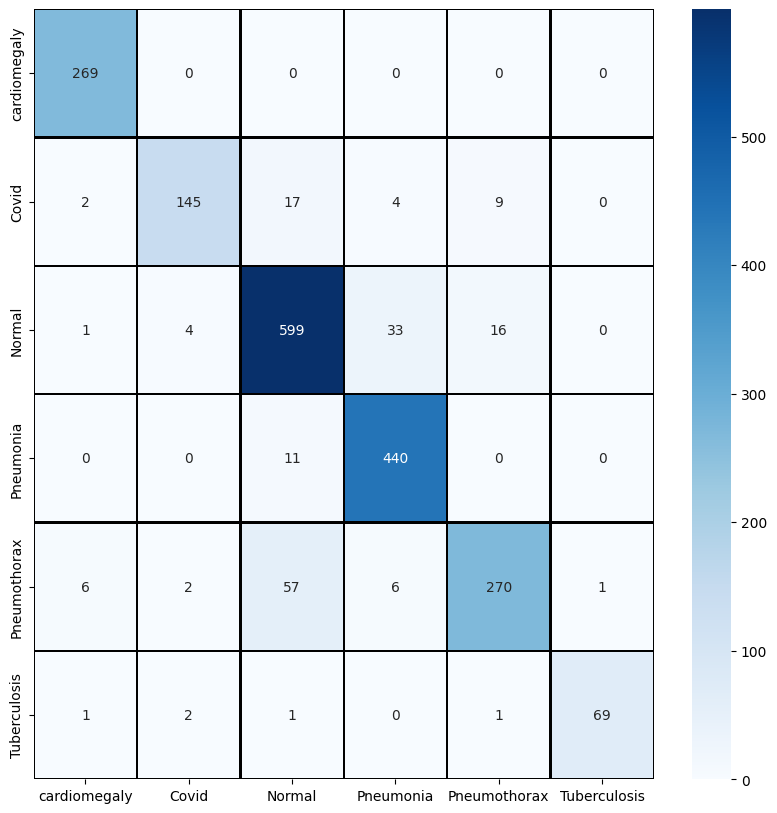

In [30]:
import seaborn as sns
labels = ['cardiomegaly','Covid','Normal','Pneumonia','Pneumothorax','Tuberculosis']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [31]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = cv2.imread("cardiomegaly.png")
image = preprocess_input(image)

Using TensorFlow backend.


AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'